# Image Inpainting using CNNs
By Daniel Manser and Daniel Rotter


## Datensatz

## Problemstellung (Rotter)

Das Ziel von Image Inpainting ist es, fehlende oder beschädigte Informationen aus Bild- oder Videomaterial zu rekonstruieren. Die Technik des Image Inpainting hat eine Vielzahl von Use-Cases ermöglicht. Image Inpainting wird aber nicht ausschließlich für fehlende Pixel verwendet, sondern auch für Aufgaben wie zum Beispiel dem Schärfen von Bildern, dem Entfernen von Rauschen oder dem Entfernen von Artefakten. 

## Herausforderungen (Rotter)

Die große Herausforderung ist es, die fehlenden oder beschädigten Teile von Bildern oder Videos sowohl visuell, als auch semantisch passend zu füllen. 

Convolutional Neural Networks (CNN) sind speziell für Rasterförmige Datensätze geeignet. Bilder können dabei als 2D Raster von Pixeln mit unterschiedlichen Farb- und Helligkeitswerten angesehen werden. Die Herausforderung bei der Umsetzung von Image Inpainting mit CNNs ist es, das Netzwerk so zu trainieren, dass es sinnvolle Vorhersagen für die fehlenden Pixel trifft.

CNN-basierte Methoden können zu Grenzartefakten, verzerrten und unscharfen Flecken am rekonstruierten Bild führen. Diese Arten von Artefakten können durch Post-processing Methoden reduziert werden, die aber vergleichsweise viel Rechenleistung erfordern und nicht so allgemein anwendbar sind. 

## Architektur (Manser)


Unsere Architektur basiert auf einem konvolutionalen Autoencoder, einer speziellen Form eines Encoder-Decoder-Modells, das in der Bildverarbeitung insbesondere für Aufgaben wie Image Inpainting eingesetzt wird. Ziel ist es, fehlende Bildbereiche auf Basis des umgebenden Kontexts möglichst realistisch zu rekonstruieren.

### Encoder

Der Encoder besteht aus einer Sequenz von Convolutional Layers (z. B. mit 3×3-Filtern), gefolgt von nichtlinearen Aktivierungsfunktionen (typischerweise ReLU - Rectified Linear Unit) und Downsampling mittels MaxPooling.
Diese Kombination reduziert die räumliche Auflösung des Bildes und extrahiert zunehmend abstrakte Merkmale. Dadurch wird eine komprimierte, semantisch bedeutungsvolle Darstellung erzeugt. [Rosebrock (2020)]

#### Pooling

**Pooling** reduziert die räumliche Auflösung einer Merkmalskarte, indem in kleinen Bereichen (z.B. 2x2 Pixel) jeweils ein einzelner Wert berechnet wird - typischerweise das Maximum (MaxPooling) oder der Mittelwert (AveragePooling). Dadurch werden Informationen verdichtet und die Modellkomplexität verringert.

### Bottleneck

Im Zentrum der Architektur befindet sich der sogenannte **Bottleneck**, eine stark verdichtete Repräsentation des ursprünglichen Bildinhalts. Sie enthält alle wesentlichen Informationen, um das Bild – inklusive der maskierten Bereiche – wiederherzustellen.
Der Bottleneck spielt eine zentrale Rolle bei der semantischen Vervollständigung des Bildes und ist charakteristisch für alle Autoencoder-basierten Ansätze.

### Decoder

Der **Decoder** kehrt den Prozess des Encoders um: Mithilfe von **Transposed Convolutions** oder **Upsampling + Convolution** wird das Bild schrittweise wieder auf seine ursprüngliche Größe gebracht. Dabei werden auch die **fehlenden Bildbereiche** rekonstruiert. Der Artikel von Weights & Biases (2022) betont, dass CNNs besonders gut darin sind, sowohl **lokale Strukturen** als auch den **globalen Kontext** wiederherzustellen - ein zentrales Kriterium für glaubwürdiges Image Inpainting.

#### Abbildung einer Autoencoder-Architektur

![Abbildung einer Autoencoder-Architektur](./images/image_autoencoder.png)

**Abbildung:** Darstellung eines symmetrischen Autoencoders mit Encoder, Bottleneck („Code“) und Decoder. Diese Architekturform bildet die Grundlage vieler Inpainting-Modelle.  
Quelle: Weights & Biases (2022) – [Introduction to Image Inpainting with Deep Learning](https://wandb.ai/wandb_fc/articles/reports/Introduction-to-image-inpainting-with-deep-learning--Vmlldzo1NDI3MjA5)

## Praktische Anwendung

### Setup

#### Wichtiger Hinweis:
Für die erfolgreiche Installation von TensorFlow ist die verwendete Python-Version entscheidend. TensorFlow 2.19.0 ist z. B. nicht kompatibel mit Python 3.13.
Wir verwenden daher gezielt Python 3.10, da diese Version offiziell von TensorFlow unterstützt wird und mit allen verwendeten Paketen kompatibel ist.

#### Verwendeter Datensatz

Für dieses Projekt wird der CIFAR-10-Datensatz verwendet, der vom *Canadian Institute for Advanced Research (CIFAR)* in Zusammenarbeit mit der *University of Toronto* entwickelt wurde. 

- Wichtige Informationen:
    - **Umfang**: 60.000 farbige Bilder
    - **Auflösung**: 32x32 Pixel pro Bild (1.024 Pixel)
    - **Farbkanal**: RGB-Kanal (Rot, Grün, Blau)
    - **Aufteilung**:
      - 10 Klassen (z.B. Flugzeug, Autos, Vögel, Katzen, etc.)
      - jeweils 6.000 Bilder pro Klasse
      - 50.000 Trainings-Bilder
      - 10.000 Test-Bilder


#### Eignung des Datensatzes für Image Inpainting

- Der CIFAR-10-Datensatz eignet sich hervorragend zur Demonstration von Inpainting-Verfahren mit CNNs, da er:
    - kompakt und damit auch ohne GPU effizient verarbeitbar ist
    - visuell vielfältig ist – die Bilder enthalten erlernbare Strukturen, Farben und Objekte
    - als RGB-Datensatz auch für reale Szenarien übertragbar ist

Die gewählte Autoencoder-Architektur kann so auf eine große Menge sinnvoller Trainingsdaten angewendet werden, ohne dass große Rechenressourcen benötigt werden.

#### Imports

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#### Daten laden und normalisieren

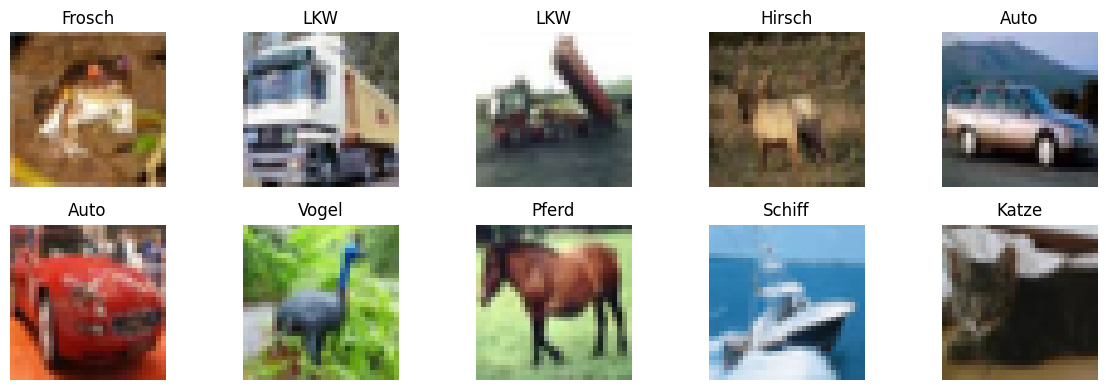

In [2]:
# CIFAR-10 laden
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalisieren (Wertebereich 0 - 1)
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# CIFAR-10 Klassenlabels
class_names = ['Flugzeug', 'Auto', 'Vogel', 'Katze', 'Hirsch', 'Hund', 'Frosch', 'Pferd', 'Schiff', 'LKW']

# Zeige die ersten 10 Bilder mit Label
plt.figure(figsize=(12, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i][0]])
    plt.axis('off')
plt.tight_layout()
plt.show()

#### Visualisierung & Qualität der CIFAR-10-Bilder

Bereits bei der ersten Betrachtung der CIFAR-10-Bilder zeigt sich deutlich, dass die Bildqualität vergleichsweise niedrig ist. Dies liegt an der Auflösung von nur 32×32 Pixeln, was bei vielen Objekten zu einem verschwommenen oder grob gepixelten Eindruck führt. Dennoch lässt sich die Objektklasse (z. B. „Auto“, „Vogel“, „Schiff“) in vielen Fällen noch erkennen, was für unsere Experimente im Bereich Image Inpainting ausreichend ist.

#### Funktion um zufällige rechteckige Masken (schwarze Bereiche) hinzuzufügen

In [3]:
def add_random_rectangle_mask(images, mask_size=(8, 8)):
    masked = np.copy(images)
    for img in masked:
        h, w = img.shape[:2]
        top = np.random.randint(0, h - mask_size[0])
        left = np.random.randint(0, w - mask_size[1])
        img[top:top+mask_size[0], left:left+mask_size[1], :] = 0.0
    return masked

x_train_masked = add_random_rectangle_mask(x_train)
x_test_masked = add_random_rectangle_mask(x_test)

#### Autoencoder definieren

In [4]:
input_img = Input(shape=(32, 32, 3))

# Teil 1: Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Teil 2: Decoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')

#### Training des CNNs

In [14]:
# Callback definieren, damit das Training (Epochs) bei gewisser Bedingung abbricht
# hier: Training stoppt automatisch, wenn sich der Validierungsverlust 5 Epochen lang nicht verbessert

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    x_train_masked, x_train,
    epochs=40,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_masked, x_test),
    callbacks=[early_stop]
)

Epoch 1/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - loss: 0.5585 - val_loss: 0.5599
Epoch 2/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - loss: 0.5586 - val_loss: 0.5595
Epoch 3/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - loss: 0.5589 - val_loss: 0.5595
Epoch 4/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 81ms/step - loss: 0.5586 - val_loss: 0.5594
Epoch 5/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 70ms/step - loss: 0.5590 - val_loss: 0.5594
Epoch 6/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - loss: 0.5591 - val_loss: 0.5595
Epoch 7/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - loss: 0.5586 - val_loss: 0.5593
Epoch 8/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - loss: 0.5586 - val_loss: 0.5592
Epoch 9/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - loss: 0.5582 - val_loss: 0.5594
Epoch 10/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 0.5584 - val_loss: 0.5593
Epoch 11/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - loss: 0.5579 - val_loss: 0.5591
Epoch 12/40
391/391 ━━━━━━━━━━

#### Plot: Trainings- vs. Validation Loss

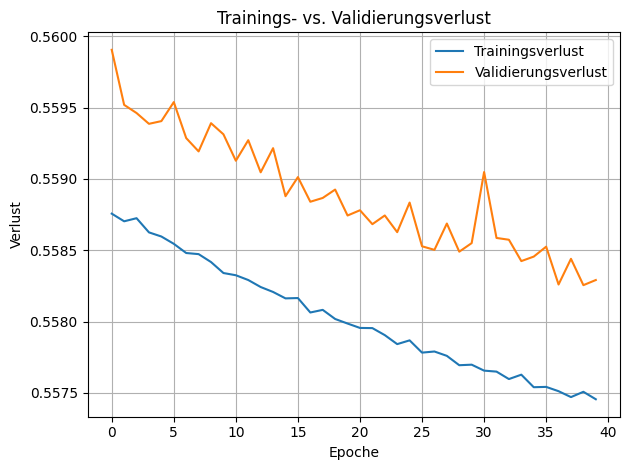

In [15]:
plt.plot(history.history['loss'], label='Trainingsverlust')
plt.plot(history.history['val_loss'], label='Validierungsverlust')
plt.xlabel('Epoche')
plt.ylabel('Verlust')
plt.title('Trainings- vs. Validierungsverlust')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("./results/verlaufsdiagramm_verlust.png", dpi=300)
plt.show()

#### Interpretation

Die oben dargestellte Grafik zeigt den Verlauf des Trainings- und Validierungsverlusts über 40 Epochen. Beide Verlustkurven zeigen einen insgesamt abnehmenden Trend, was auf eine erfolgreiche Optimierung des Autoencoders hinweist.

Obwohl der Validierungsverlust im Vergleich zum Trainingsverlust leicht höhere Werte und stärkere Schwankungen aufweist, verlaufen beide Kurven relativ eng beieinander. Dies deutet darauf hin, dass das Modell nicht überfittet und gut auf unbekannte Testdaten generalisiert.

Das Training wurde durch ein Early-Stopping-Callback kontrolliert, das eine Überanpassung zusätzlich verhindert. Insgesamt lässt der Verlauf der Kurven auf eine geeignete Modellkomplexität und eine ausreichende Anzahl an Epochen schließen.

#### Modell speichern

In [7]:
autoencoder.save("models/autoencoder_cifar10.keras")

#### Ergebnisse visualisieren

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


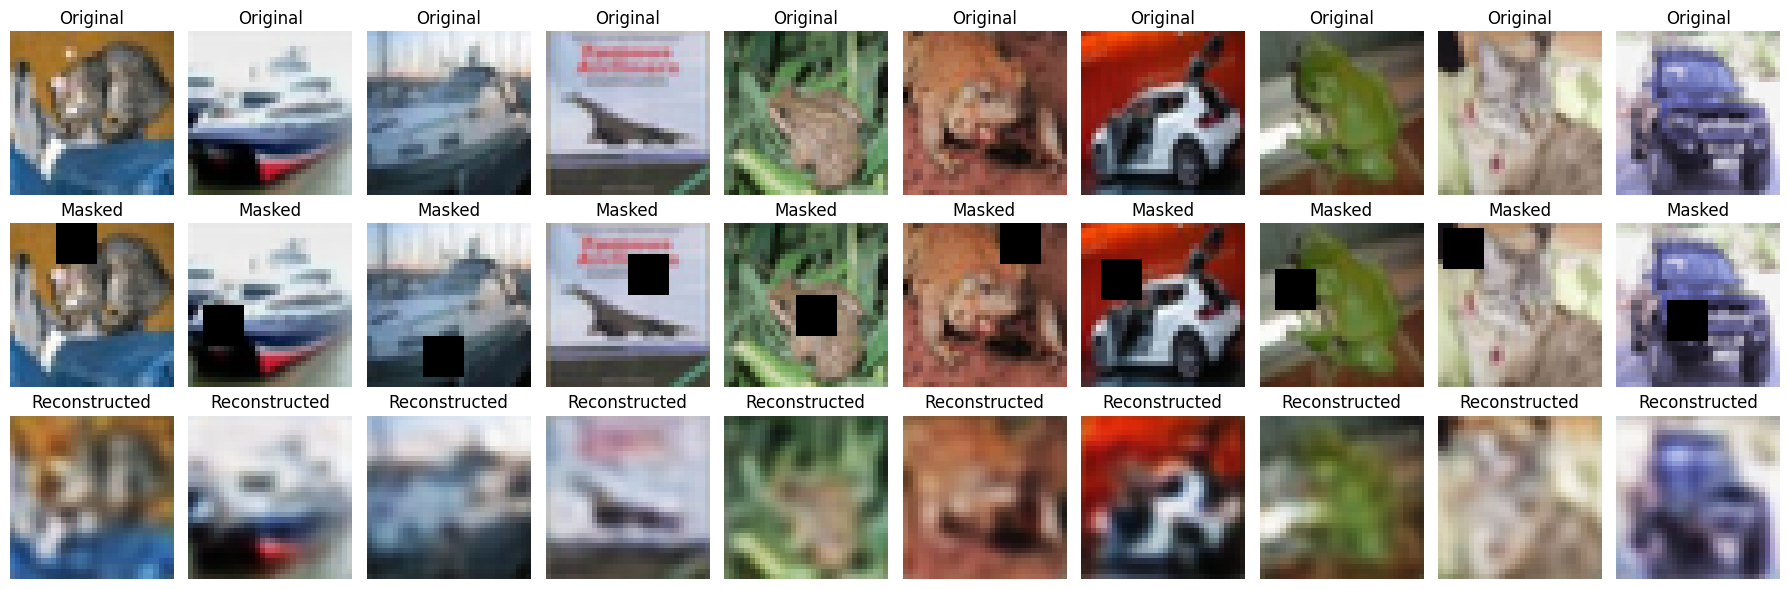

In [ ]:
decoded_imgs = autoencoder.predict(x_test_masked[:10])

n = 10
plt.figure(figsize=(18, 6))
for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1) # plt.subplot(nrows, ncols, index)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis("off")

    # Masked
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_masked[i])
    plt.title("Masked")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstructed")
    plt.axis("off")
plt.tight_layout()
plt.savefig("./results/inpainting_result_cifar10.png", dpi=300)
plt.show()

## Literaturverzeichnis 
- Waghela, V. (2022). Image Inpainting using CNN. Kaggle.
https://www.kaggle.com/code/vidhikishorwaghela/image-inpainting-using-cnn

- Weights & Biases. (2022). Introduction to Image Inpainting with Deep Learning.
https://wandb.ai/wandb_fc/articles/reports/Introduction-to-image-inpainting-with-deep-learning--Vmlldzo1NDI3MjA5

- Rosebrock, A. (2020). Autoencoders with Keras, TensorFlow, and Deep Learning.
https://pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/

## Executive Summary
- Kurzbeschreibung Datensatz
- Kurzbeschr. der Methode
- Verwendete Software
- Wichtigste Erkenntnisse und Resultate
- Zentrale Herausforderungen

## Appendix

### Konsolenausgabe bei Training 